# Generation of Random Variate

In [24]:
# Amitava Chakraborty 22 Dec 2019

#Classical computers use pseudo-random routines
#Quantum computers can generate true random variates. 

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys, math, time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
from qiskit import BasicAer
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.visualization import plot_histogram
q_backend = BasicAer.get_backend("qasm_simulator")

# 1. Measurement of a quantum superposition is intrinsically random

We create a quantum circuit of $n$ qubits and apply a $H-gate$ in each qubit. We then measure the circuit $m$ times.
Each measurement with produce either a $0$ or an $1$ for each qubit. Hence, in each measurement, we will get a bit-pattern of $n \mbox{bit}$. This way, after $m$ measurements, we can create a bit pattern of $m\cdot n$ bits - and that bit pattern is intrinsically random.

Suppose we need a random bit pattern of $100$ bits. We can achieve this with a quantum circuit involving $4$ qubits, measuring the circuit $25$ times.

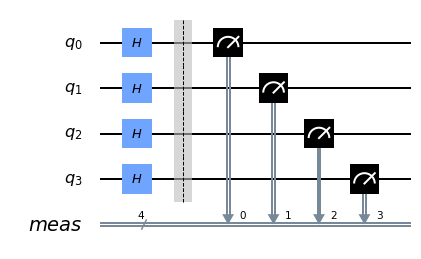

In [25]:
#We create a n-qubit system, here a 2-qubit one
qc = QuantumCircuit(4)
#We apply H gates to both the qubits
qc.h([0,1,2,3])
#qc.h(1)
qc.measure_all()#([0,1],[0,1])
qc.draw('mpl')

['1101', '0100', '0110', '1110', '0001', '1000', '0001', '0011', '1001', '0000', '0100', '0111', '1100', '0111', '1110', '0000', '1101', '1010', '1101', '0101', '0001', '0011', '0101', '0010', '1101']
Random Bit String :  1101010001101110000110000001001110010000010001111100011111100000110110101101010100010011010100101101
Random Bit String Length :  100


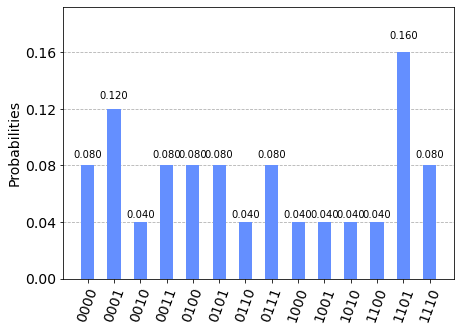

In [26]:
# We measure the circuit m times (shots=m)
results = execute(qc, q_backend, shots=25, memory=True).result()
#We get a pure random number of n x m bits
print(results.get_memory())
bit_str = ''.join(results.get_memory())
print('Random Bit String : ',bit_str)
print('Random Bit String Length : ',len(bit_str))
plot_histogram(results.get_counts())

#Random Bits and the Bernoulli distribution
#(i.e., Bernoulli-distributed scalars, taking values either 0 or 1). 
#Starting from a simple circuit such as a Hadamard gate followed by measurement, 
#one can progress to vectors of Bernoulli-distributed elements. 
#By addition of such random variates, we could get binomial distributions. 
#By multiplication we could get geometric distributions, 
#although perhaps leading to a circuit depth that may be impractical at the moment, though.

#Let us start by importing the basic modules and creating a quantum circuit for generating random bits:

In [27]:
#We create a quantum circuit, which is just an extension of the above circuit
#To generate a random number
def get_random_variate_circuit(num_target_qubits: int) -> QuantumCircuit:
    """
    Creates and returns a quantum circuit for random variate generation.
    :param num_target_qubits: number of qubits to be used.
    :return: quantum curcuit.
    """
    qr = QuantumRegister(num_target_qubits)
    cr = ClassicalRegister(num_target_qubits)
    circuit = QuantumCircuit(qr, cr)
    circuit.h(qr)
    circuit.barrier()
    circuit.measure(qr, cr)
    return circuit

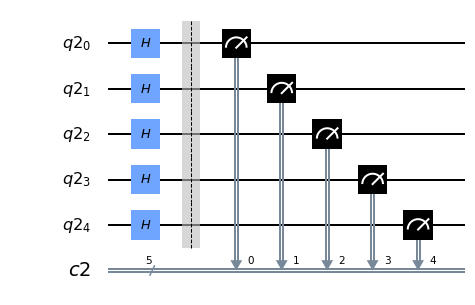

In [28]:
# Create and plot generating quantum circuit.
# Number of qubits utilised simultaneously.
num_qubits = 5
circuit = get_random_variate_circuit(num_qubits)
circuit.draw(output='mpl')

In [40]:
#Uniformly-distributed scalars and vectors
#It is clear that there are many options for approximating uniformly-distributed scalars 
#by the choice of an integer from a finite range uniformly at random, 
#e.g., by a binary-code construction from the Bernoulli-distributed vectors. 

#In the following snippet, we generate random bits, 
#which we then convert using the binary-code construction, 
#up to the machine precision of a classical computer.
def get_uniform_random(circuit: QuantumCircuit, num_target_qubits: int,
                         size: int, bounds: [float,float], iInt: bool) -> np.ndarray:
    """
    Generates a vector of random float64(default)/or int values in the range bounds[min_value, max_value].
    :param circuit: quantum circuit for random variate generation.
    :param num_target_qubits: number of qubits to be used.
    :param size: length of the vector.
    :param bounds: [lower bound, upper bound]
    :param iInt: whether int values are needed
    :return: vector of random values.
    """
    vmin=float(bounds[0])
    vmax=float(bounds[1])

    # Mantissa of float64 uses 7 bytes
    float64_bits = 7 * 8                                   
    bit_str_len = (float64_bits * size + num_target_qubits - 1) // num_target_qubits
    print(bit_str_len)
    job = execute(circuit, q_backend, shots=bit_str_len, memory=True)
    bit_str = ''.join(job.result().get_memory())
    scale = float(vmax - vmin) / float(2**float64_bits - 1)
    array = np.array([vmin + scale * float(int(bit_str[i:i+float64_bits], 2))
                     for i in range(0, float64_bits * size, float64_bits)], dtype=np.float64)
    print(array)
    if iInt == True:
        array = np.rint(array).astype(np.int64)
    return array

700
[ 7.28915283 23.035868   19.38188874 10.836742   16.6202602   4.77198371
 -1.02731455 15.78009399 13.9749804  10.62728899  4.43802491  5.47212605
 21.77718104 -3.82599519  3.26497421 13.40379433 22.67882225  9.65762551
 16.88807402 13.59837488  0.99244811 11.08090449  8.22504778  6.58189316
  8.40229049 -1.44039353 -7.37611608 -7.44687894 23.26441734 14.15947256
 -2.57485839 10.80930139  5.34637997 -5.7781648  14.7445944   3.03533085
  4.48084304 -2.49829233 -0.27025747 12.30290456 -0.78779616 -2.57713785
 19.47635614  4.62183997 -7.5430377   4.89597021  1.96764858 18.85052951
 15.30567681 -7.48663116]
Uniform distribution over floating point numbers:
sample type: <class 'numpy.ndarray'> , element type: float64 , shape: (50,)
sample min: -7.5430, max: 23.2644


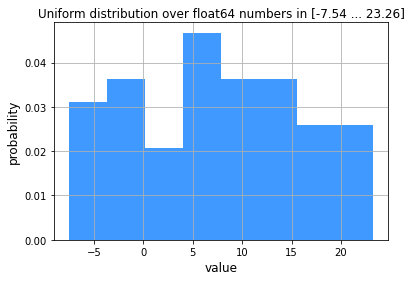

In [41]:
#Uniform distribution over floating point numbers - a random vector of floating-point values uniformly distributed 
#within some arbitrary selected interval:

# Draw a sample from uniform distribution.
sample = get_uniform_random(circuit, 4, size=50, bounds=[-8.2,23.3], iInt=False)

# Print out some details.
print("Uniform distribution over floating point numbers:")
print("sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("sample min: {:.4f}, max: {:.4f}".format(np.amin(sample), np.amax(sample)))

# Plotting the distribution.
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='#0077ff', alpha=0.75)
plt.xlabel("value", size=12)
plt.ylabel("probability", size=12)
plt.title("Uniform distribution over float64 numbers in [{:.2f} ... {:.2f}]".format(
            np.amin(sample), np.amax(sample)), size=12)
plt.grid(True)
# plt.savefig("uniform_distrib_float.png", bbox_inches="tight")
plt.show()

560
[ 46.47093644  67.76814178 107.42110385  51.99251904  27.20798512
  99.49993402  86.96831973  52.37701638  19.54811919  19.78475848
  17.71426169  75.89473725  80.75348825  83.9741187   16.44773409
  93.75626001 110.85960423  92.50133606  36.79540072  61.47407084
  33.55731259  34.86630735  95.80596629  83.29791972  76.36970525
  43.03768716  46.90142797  15.47395685  91.20415981  61.24342517
  12.49844515 110.3723231   62.42470115  60.84014229  74.56938375
 100.1648558   97.67864186 105.23290289  13.85805201  44.31539704
  17.06416136  35.99831518  45.36109138  25.93607952  60.60140173
  45.78530257  51.95203252  81.78146193 108.37202804  12.52188676]
Uniform distribution over bounded integer numbers:
sample type: <class 'numpy.ndarray'> , element type: int64 , shape: (50,)
sample min: 12, max: 111


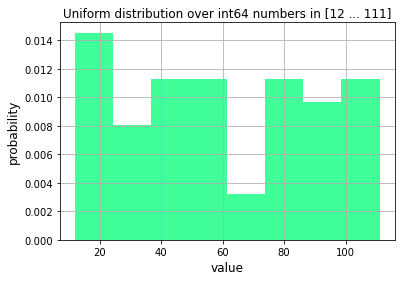

In [42]:
#Uniform distribution over integers - a random vector of integers:

# Draw a sample from uniform distribution.
sample = get_uniform_random(circuit, num_qubits, size=50, bounds=[11,112], iInt=True)

# Print out some details.
print("Uniform distribution over bounded integer numbers:")
print("sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("sample min: {:d}, max: {:d}".format(np.amin(sample), np.amax(sample)))

# Plotting the distribution.
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='#00ff77', alpha=0.75)
plt.xlabel("value", size=12)
plt.ylabel("probability", size=12)
plt.title("Uniform distribution over int64 numbers in [{:d} ... {:d}]".format(
            np.amin(sample), np.amax(sample)), size=12)
plt.grid(True)
# plt.savefig("uniform_distrib_int.png", bbox_inches="tight")
plt.show()

In [37]:
#Normal distribution
#To generate random variates with a standard normal distribution using two independent samples 
#$u_1, u_2$ of the uniform distribution on the unit interval [0, 1], 
#one can consider the Box-Muller transform to obtain a 2-vector:

#$$\begin{align}
#\begin{bmatrix}
#%R\cos(\Theta )=
#{\sqrt {-2\ln u_{1}}}\cos(2\pi u_{2}) \\
#% R\sin(\Theta )=
#{\sqrt {-2\ln u_{1}}}\sin(2\pi u_{2})
#\end{bmatrix},
#\end{align}$$
#wherein we have two independent samples of the standard normal distribution. 
#In IBM Q, this is implemented as follows:
def normal_rand_float64(circuit: QuantumCircuit, num_target_qubits: int,
                        size: int, mu: float, sigma: float) -> np.ndarray:
    """
    Draws a sample vector from the normal distribution given the mean and standard
    deviation, using the Box-Muller method. 
    """
    TINY = np.sqrt(np.finfo(np.float64).tiny)
    assert isinstance(size, int) and size > 0
    rand_vec = np.zeros((size,), dtype=np.float64)

    # Generate array of uniformly distributed samples, factor 1.5 longer that
    # actually needed.
    n = (3 * size) // 2
    x = np.reshape(get_uniform_random(circuit, num_target_qubits,
                                        2*n, [0.0, 1.0],iInt=False), (-1, 2))

    x1 = 0.0                # first sample in a pair
    c = 0                   # counter
    for d in range(size):
        r2 = 2.0
        while r2 >= 1.0 or r2 < TINY:
            # Regenerate array of uniformly distributed samples upon shortage.
            if c >= n:
                c = 0
                n = max(size // 10, 1)
                x = np.reshape(get_uniform_random(circuit, num_target_qubits,
                                                    2*n, [0.0, 1.0],iInt=False), (-1, 2))

            x1 = 2.0 * x[c, 0] - 1.0        # first sample in a pair
            x2 = 2.0 * x[c, 1] - 1.0        # second sample in a pair
            r2 = x1 * x1 + x2 * x2
            c += 1

        f = np.sqrt(np.abs(-2.0 * np.log(r2) / r2))
        rand_vec[d] = f * x1
        
    return (rand_vec * sigma + mu)

In [38]:
#The following example demonstrates how to draw a random vector of normally distributed variates:

# Mean and standard deviation.
mu = 2.4
sigma = 5.1

# Draw a sample from the normal distribution.
start_time = time.time()
sample = normal_rand_float64(circuit, num_qubits, size=50, mu=mu, sigma=sigma)
sampling_time = time.time() - start_time

# Print out some details.
print("Normal distribution (mu={:.3f}, sigma={:.3f}):".format(mu, sigma))
print("  sample type:", type(sample), ", element type:", sample.dtype, ", shape:", sample.shape)
print("  sample min: {:.4f}, max: {:.4f}".format(np.amin(sample), np.amax(sample)))
print("  sampling time: {:.2f} secs".format(sampling_time))

1680
[8.24171757e-01 9.94099201e-01 6.39594198e-01 1.00762184e-01
 3.56480328e-01 3.09950966e-01 1.69877453e-01 1.86946531e-01
 7.42200727e-01 5.01351276e-01 4.26315444e-01 8.37163219e-01
 9.59107950e-01 6.95624018e-02 5.31405232e-01 9.01168535e-01
 6.22634909e-01 7.55946321e-01 7.55993553e-01 5.37852534e-01
 7.95911136e-01 1.39240317e-01 8.53854908e-01 9.26466449e-02
 7.08613741e-01 6.70984636e-01 7.96707490e-01 3.37507272e-01
 1.51535265e-01 1.82543992e-01 4.59911407e-01 5.31212179e-01
 6.88605506e-01 5.40555208e-01 9.99503250e-01 3.34136951e-01
 9.78375900e-01 9.35481309e-01 4.96289022e-01 7.64171549e-01
 2.71382587e-01 3.18785619e-01 3.49703788e-01 4.85646359e-01
 5.85613330e-01 5.27023724e-02 7.61431238e-01 2.60386511e-02
 2.50404726e-01 3.39119151e-01 9.83858879e-01 9.40569324e-01
 3.37331079e-01 8.58743836e-01 6.14730292e-01 5.85073173e-01
 2.96245821e-02 4.45311319e-01 2.11366951e-01 6.08206193e-01
 6.16541428e-01 5.13193750e-01 2.55014209e-01 3.38128690e-02
 4.94510762e-02 4.1

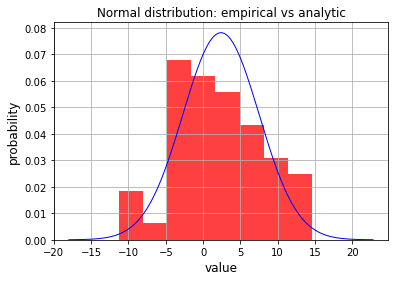

In [39]:
# Plotting the distribution.
x = np.linspace(mu - 4.0 * sigma, mu + 4.0 * sigma, 1000)
analyt = np.exp(-0.5 * ((x - mu) / sigma)**2) / (sigma * math.sqrt(2.0 * math.pi))
plt.hist(sample.ravel(),
         bins=min(int(np.ceil(np.sqrt(sample.size))), 100),
         density=True, facecolor='r', alpha=0.75)
plt.plot(x, analyt, '-b', lw=1)
plt.xlabel("value", size=12)
plt.ylabel("probability", size=12)
plt.title("Normal distribution: empirical vs analytic", size=12)
plt.grid(True)
# plt.savefig("normal_distrib.png", bbox_inches="tight")
plt.show()
#There is a substantial amount of further work needed to either certify the quality of the source 
#of random numbers 
#(cf. NIST SP 800-90B, Recommendation for the Entropy Sources Used for Random Bit Generation) or 
#to use random variates within quantum algorithms (cf. uncertainty_models within Qiskit Aqua).